In [92]:
import os

import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import v2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shap

seed = 67

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("done")


done


In [93]:
# Load Dataset Metadata
metadata_path = "./Garbage_data/Garbage_Dataset_Classification/metadata.csv"
metadata_df = pd.read_csv(metadata_path)


def get_file_path(metadata):
    image_folder = "./Garbage_data/Garbage_Dataset_Classification/images/"
    return os.path.join(image_folder, metadata["label"], metadata["filename"])


class GarbageDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.metadata_df = metadata_df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        metadata = self.metadata_df.iloc[idx]
        img_path = get_file_path(metadata)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = metadata["label"]

        if self.transform:
            image = self.transform(image)

        label_idx = label_to_idx[label]
        return image, label_idx


split_seed = 13

metadata_train_df, metadata_val_df = train_test_split(
    metadata_df, random_state=split_seed, stratify=metadata_df["label"].values
)

labels = sorted(metadata_df["label"].unique())
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Data Augmentation & Preprocessing
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.RandomResizedCrop(size=(256, 256), antialias=True),
        v2.RandomPhotometricDistort(p=0.5),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize(256, antialias=True),
        v2.CenterCrop(256),
        v2.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)



trainset = GarbageDataset(metadata_train_df, transform=transform)
testset = GarbageDataset(metadata_val_df, transform=test_transform)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, shuffle=False)

# change device (for mac use mainly)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [94]:
# load model definitions 
class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 128x128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x64
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x32
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class AxNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0):
        super(AxNet, self).__init__()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 63->31
            nn.Conv2d(96, 256, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 31->15
            nn.Conv2d(256, 384, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),  # 15-> 15
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),  # 15-> 15
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 15-> 7
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Define Ensemble Model to combine both LeNet and CustomCNN
class EnsembleCNN(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleCNN, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        ensemble_output = (output1 + output2) / 2  # Averaging logits
        return ensemble_output
    
print("done")


done


In [95]:
# load model 
customcnn_model = CustomCNN(num_classes=6).to(device)
Ax_model = AxNet(num_classes=6, dropout_rate=0.15).to(device)
# Create the ensemble model
ensemble_model = EnsembleCNN(Ax_model, customcnn_model).to(device)
PATH = "Ensemble_model_states.pth"
ensemble_model.load_state_dict(torch.load(PATH, map_location=device))



<All keys matched successfully>

              precision    recall  f1-score   support

   cardboard       0.82      0.85      0.83       554
       glass       0.87      0.83      0.85       625
       metal       0.81      0.88      0.84       521
       paper       0.85      0.83      0.84       579
     plastic       0.83      0.78      0.81       572
       trash       0.81      0.83      0.82       625

    accuracy                           0.83      3476
   macro avg       0.83      0.83      0.83      3476
weighted avg       0.83      0.83      0.83      3476



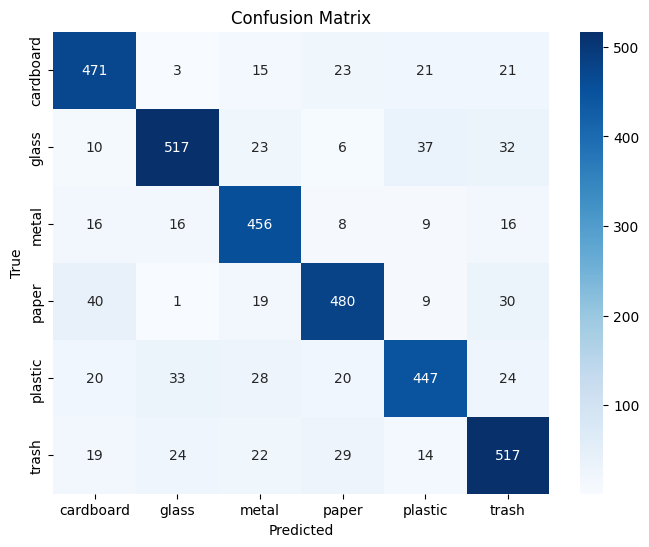

In [96]:
ensemble_model.eval()
all_preds = []
all_labels = []

# get preds 
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# reset def of labels
labels = sorted(metadata_df["label"].unique())

print(classification_report(all_labels, all_preds, target_names=labels))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            cmap="Blues", xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
    
# confusion_matrix(ensemble_model, testloader, device, labels)